In [1]:
import sys  
sys.path.append('../scripts/')
from mcl import *
from kf import * 

## EstimatedLandmarkクラス
---
ランドマークの推定位置を描写

In [2]:
class EstimatedLandmark(Landmark):
    def __init__(self):
        super().__init__(0,0) 
        self.cov = None #変更
        
    def draw(self, ax, elems): 
        if self.cov is None:
            return
        
        ###推定位置に青い星を描く###
        c = ax.scatter(self.pos[0], self.pos[1], s=100, marker="*", label="landmarks", color="blue")
        elems.append(c)
        elems.append(ax.text(self.pos[0], self.pos[1], "id:" + str(self.id), fontsize=10))
        
        ###誤差楕円を描く###
        e = sigma_ellipse(self.pos, self.cov, 10)
        elems.append(ax.add_patch(e))

## MapParticleクラス
---
各パーティクルが持つ情報

- 推定したロボットの位置姿勢
- 重み
- 地図情報（各ランドマークの位置推定におけるガウス分布（中心と共分散））

In [3]:
class MapParticle(Particle):  
    def __init__(self, init_pose, weight, landmark_num):
        super().__init__(init_pose, weight)
        self.map = Map()
        
        for i in range(landmark_num):
            self.map.append_landmark(EstimatedLandmark())
        
        
    def init_landmark_estimation(self, landmark, z, distance_dev_rate, direction_dev):
        # 初めてランドマークを観測したとき、ランドマークの位置推定のガウス分布を初期化
        # これはランドマークの位置推定を行う際、一つ前の情報を必要とするため

        x, y, t = self.pose
        ell, phi = z
        
        # 観測値zからランドマークの位置推定のガウス分布の中心(mx, my)を算出
        mx, my = ell*math.cos(t + phi) + x, ell*math.sin(t + phi) + y
    
        # ランドマークの観測関数h(m)を線形化した行列Hを算出
        # ランドマークの位置推定をガウス分布を用いて表すために線形化が必要
        H = np.array([[(mx - x)/math.sqrt(ell), (my - y)/math.sqrt(ell)], 
                                [                     (y - my)/ell,                   (mx - x)/ell]])
        
        # あらかじめ設定したランドマークの観測における誤差の標準偏差から共分散行列Qを算出
        Q = np.diag(np.array([(distance_dev_rate*ell)**2, direction_dev**2]))
        
        # ここまでに求めたHとQよりランドマークの位置推定のガウス分布を初期化
        landmark.cov = np.linalg.inv(H.T.dot( np.linalg.inv(Q) ).dot(H))
        landmark.pos = np.array([mx, my]).T
        
        
    def observation_update_landmark(self, landmark, z, distance_dev_rate, direction_dev):  ###fastslam7
        # 二度目以降のランドマークの観測では、各パーティクルが持つ重みとランドマークの位置推定のガウス分布を更新
        
        x, y, _ = self.pose
        mx, my =  landmark.pos
        estm_z = IdealCamera.relative_polar_pos(self.pose, landmark.pos)
        estm_ell, _ = estm_z
        if estm_ell < 0.01:
            return
        
        # init_landmark_estimation関数と同じようにHとQを算出
        H = np.array([[(mx - x)/math.sqrt(estm_ell), (my - y)/math.sqrt(estm_ell)],  [(y - my)/estm_ell, (mx - x)/estm_ell]])
        Q = np.diag(np.array([(distance_dev_rate*estm_ell)**2, direction_dev**2]))
        
        # HとQからカルマンゲインKを算出
        # カルマンゲインKは一つ前のランドマークの位置推定のガウス分布（中心）が、次の観測後にどれだけ変化するかを表す
        K = landmark.cov.dot(H.T).dot( np.linalg.inv(Q + H.dot(landmark.cov).dot(H.T)) )
        
        ###重みの更新###
        # 各パーティクルの重みはそのときの観測値から尤度関数に則って更新
        # 尤度関数をガウス分布で表し、平均はそのパーティクルから見たランドマークの位置推定のガウス分布の中心の距離、共分散はランドマークの位置推定のガウス分布の共分散とQから算出
        # パーティクルが自己位置とランドマークの位置を推定できたとき、そこから観測値を推定することができるため、尤度関数を求めることが可能
        Q_z = H.dot(landmark.cov).dot(H.T) + Q
        self.weight *= multivariate_normal(mean=estm_z, cov=Q_z).pdf(z)
        
        ###ランドマークの推定の更新###
        # 現在の観測値と一つ前の観測値の差と、カルマンゲインKからランドマークの位置推定のガウス分布を更新
        landmark.pos = K.dot(z - estm_z) + landmark.pos
        landmark.cov = (np.eye(2) - K.dot(H)).dot(landmark.cov)
        
    def observation_update(self, observation, distance_dev_rate, direction_dev): 
        for d in observation:
            z = d[0]
            landmark = self.map.landmarks[d[1]]
            
            if landmark.cov is None:
                self.init_landmark_estimation(landmark, z, distance_dev_rate, direction_dev)
            else:
                self.observation_update_landmark(landmark, z, distance_dev_rate, direction_dev)

## FastSLAMクラス
---
FastSLAM用のパーティクルを用意（各パーティクルはMapParticleの要素を持つ）
- observation_update : 各パーティクルの観測
- set_ml : 重みが最大のパーティクルをセット
- resampling : リサンプリング

最も重みが大きいパーティクルの地図情報を描写

In [4]:
class FastSlam(Mcl):
    def __init__(self, particle_num, init_pose, landmark_num, motion_noise_stds={"nn":0.19, "no":0.001, "on":0.13, "oo":0.2}, \
                 distance_dev_rate=0.14, direction_dev=0.05):
        super().__init__(None, init_pose, particle_num, motion_noise_stds, distance_dev_rate, direction_dev)
        
        self.particles = [MapParticle(init_pose, 1.0/particle_num, landmark_num) for i in range(particle_num)]
        self.ml = self.particles[0]
        
    def observation_update(self, observation):  
        for p in self.particles:
            p.observation_update(observation, self.distance_dev_rate, self.direction_dev) #self.mapを削除
        self.set_ml()
        self.resampling() 
        
    def draw(self, ax, elems):
        super().draw(ax, elems)
        self.ml.map.draw(ax, elems)

## メイン関数
---
環境を作成

- 地図
- ランドマーク
- エージェント
- ロボット

<IPython.core.display.Javascript object>


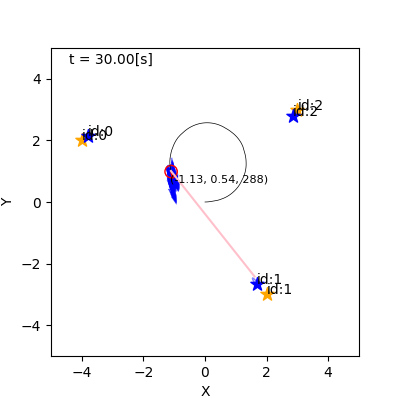

In [5]:
if __name__ == '__main__': 
    time_interval = 0.1
    world = World(30, time_interval) 

    ###真の地図を作成###
    m = Map()
    landmark_positions = [(-4,2), (2,-3), (3,3)]
    for p in landmark_positions:
        m.append_landmark(Landmark(*p))
        
    world.append(m)       #ここより上は省略

    ### ロボットを作る ###
    init_pose = np.array([0,0,0]).T
    pf = FastSlam(100, init_pose, len(m.landmarks))
    a = MclAgent(time_interval, 0.2, 10.0/180*math.pi, pf)
    r = Robot(init_pose, sensor=Camera(m), agent=a, color="red")
    world.append(r)

    world.draw()

In [6]:
a.pf.particles[10].map.landmarks[2].cov

In [7]:
math.sqrt(0.0025)

0.05

h(m)144